In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, GRU 

In [2]:
#In this case for image collection, though usually there would be an input: a smack of the machine, followed by another to take from a \
# dedicated database
!pip install kaggle
import json
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username": <KAGGLE USERNAME>, "key": <KAGGLE API KEY>}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ysjprojects/asl-signs
!unzip asl-signs.zip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 27% 5.00M/18.8M [00:00<00:00, 43.5MB/s]
100% 18.8M/18.8M [00:00<00:00, 100MB/s] 
Archive:  asl-signs.zip
  inflating: dataset/A/1.jpg         
  inflating: dataset/A/10.jpg        
  inflating: dataset/A/100.jpg       
  inflating: dataset/A/101.jpg       
  inflating: dataset/A/102.jpg       
  inflating: dataset/A/103.jpg       
  inflating: dataset/A/104.jpg       
  inflating: dataset/A/105.jpg       
  inflating: dataset/A/106.jpg       
  inflating: dataset/A/107.jpg       
  inflating: dataset/A/108.jpg       
  inflating: dataset/A/109.jpg       
  inflating: dataset/A/11.jpg        
  inflating: dataset/A/110.jpg       
  inflating: dataset/A/111.jpg       
  inflating: dataset/A/112.jpg       
  inflating: dataset/A/113.jpg       
  inflating: dataset/A/114.jpg       
  inflating: dataset/A/115.jpg       
  inflating: dataset/A/116.jpg       
  inflating: dataset/A/117.jpg     

In [6]:
batch_size = 32
img_height = 128
img_width = 128

In [3]:
import pathlib
data_dir = pathlib.Path("/content/dataset")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4050


In [4]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            brightness_range=(0.5,1), 
                            zoom_range=0.2,
                            channel_shift_range=0.2,
                            rescale=1./255,
                            validation_split=0.3)


In [7]:
# train val split

train_ds = img_generator.flow_from_directory(
    directory=data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=True,
    subset="training")

val_ds = img_generator.flow_from_directory(
    directory=data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    shuffle=True,
    subset="validation")


Found 2835 images belonging to 27 classes.
Found 1215 images belonging to 27 classes.


In [9]:
import os
classes = os.listdir(data_dir)
classes.sort()
print(classes)
print(len(classes))


['A', 'B', 'BLANK', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
27


In [10]:
N=list(range(len(classes)))
normal_mapping=dict(zip(classes,N))
reverse_mapping=dict(zip(N,classes))


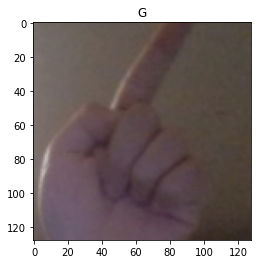

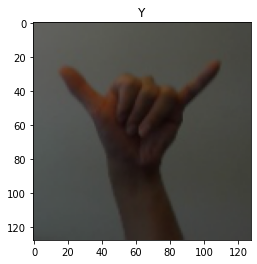

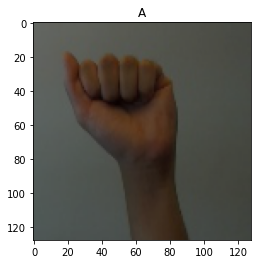

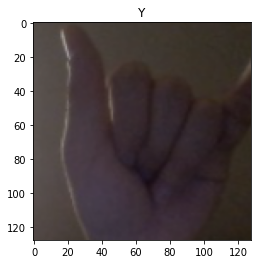

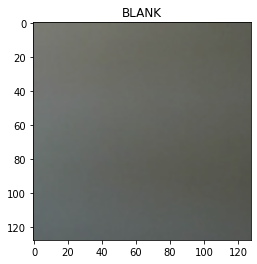

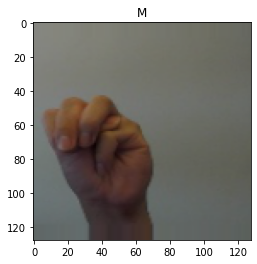

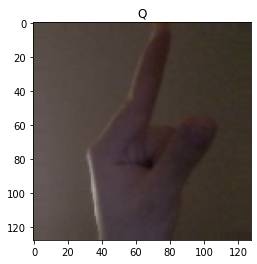

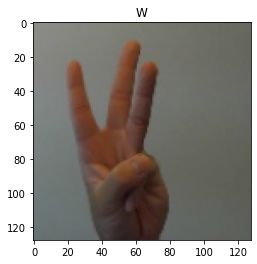

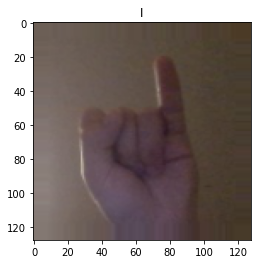

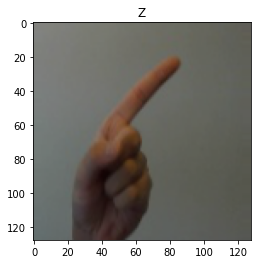

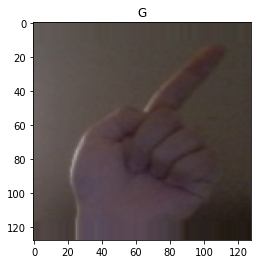

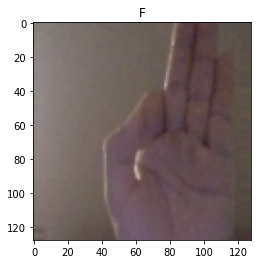

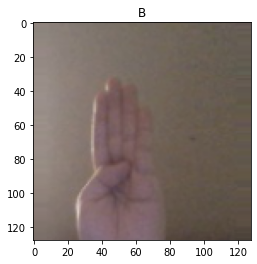

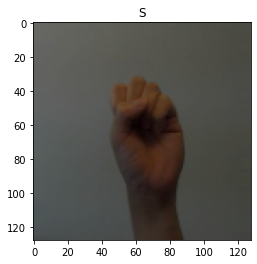

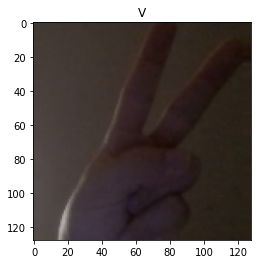

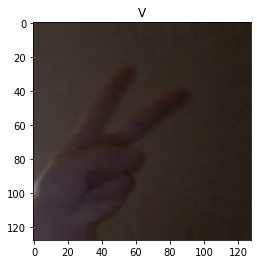

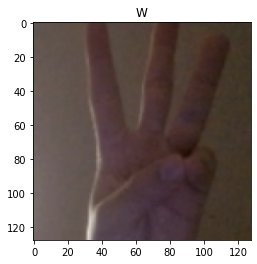

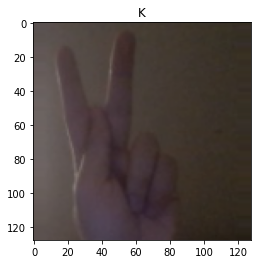

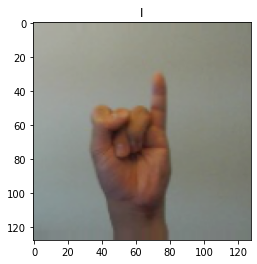

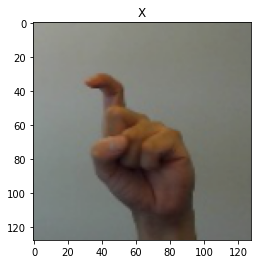

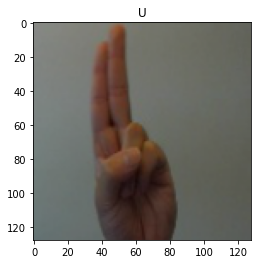

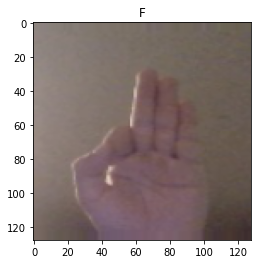

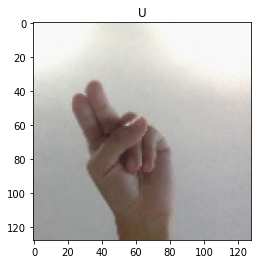

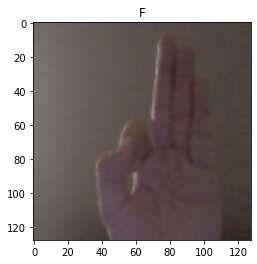

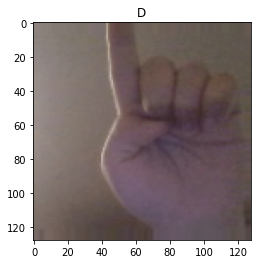

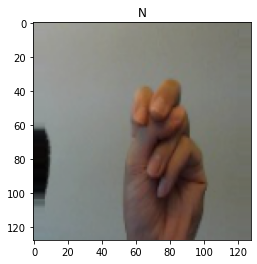

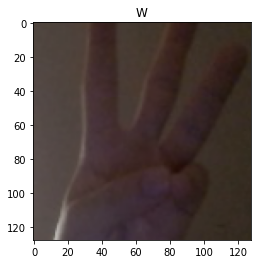

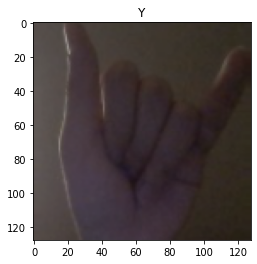

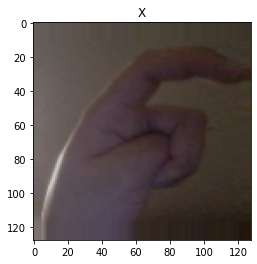

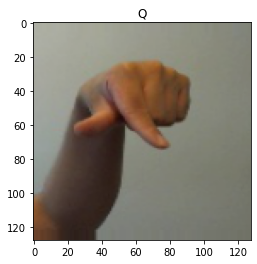

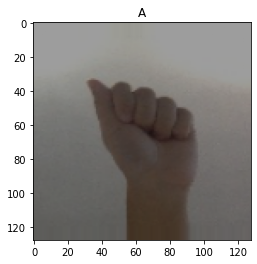

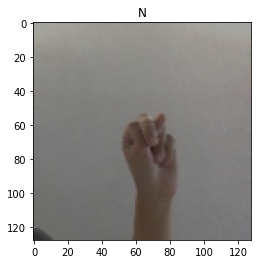

In [11]:
imgs, labels = next(iter(train_ds))
for img, label in zip(imgs, labels):
    value=np.argmax(label)
    labelname=reverse_mapping[value]
    plt.imshow(img)
    plt.title(labelname)
    plt.show()


In [12]:
# Transfer learning: load pre-trained model

base_model = tf.keras.applications.InceptionV3(input_shape=(img_height,img_width,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )


87910968/87910968 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = False

In [14]:
num_classes = len(classes)
print(num_classes)

model = Sequential([
  base_model,
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes, activation = "softmax")
])

27


In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), # easy to use and for computation but not as reliable as others
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=10,restore_best_weights=True, monitor='val_categorical_accuracy')
epochs=64


In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  steps_per_epoch=32,
  epochs=epochs,
  callbacks=[early_stopping_monitor]
)

Epoch 1/64
32/32 [==============================] - 79s 2s/step - loss: 3.3010 - categorical_accuracy: 0.2783 - val_loss: 2.7222 - val_categorical_accuracy: 0.3045
Epoch 2/64
32/32 [==============================] - 70s 2s/step - loss: 1.2233 - categorical_accuracy: 0.6479 - val_loss: 2.0048 - val_categorical_accuracy: 0.4724
Epoch 3/64
32/32 [==============================] - 68s 2s/step - loss: 0.7338 - categorical_accuracy: 0.7891 - val_loss: 1.5173 - val_categorical_accuracy: 0.5523
Epoch 4/64
32/32 [==============================] - 68s 2s/step - loss: 0.5865 - categorical_accuracy: 0.8340 - val_loss: 1.5361 - val_categorical_accuracy: 0.5654
Epoch 5/64
32/32 [==============================] - 68s 2s/step - loss: 0.4574 - categorical_accuracy: 0.8643 - val_loss: 1.3062 - val_categorical_accuracy: 0.6453
Epoch 6/64
32/32 [==============================] - 68s 2s/step - loss: 0.3463 - categorical_accuracy: 0.9043 - val_loss: 1.2671 - val_categorical_accuracy: 0.6634
Epoch 7/64
32/32

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 27)                55323     
                                                                 
Total params: 21,858,107
Trainable params: 55,323
Non-trainable params: 21,802,784
_________________________________________________________________


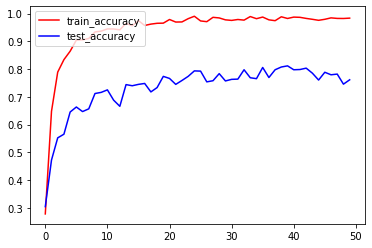

In [19]:
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()


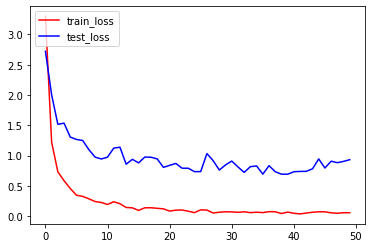

In [20]:
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()


In [21]:
model.save("/content/model")

In [22]:
!zip -r /content/model.zip /content/model

from google.colab import files
files.download("/content/model.zip")


  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 92%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 76%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>